In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('recons-iter.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCCAATTGGCGGAGTAAGCGCG...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCGCAGGGTATATGGT...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 82398.13it/s]


[98, 230, 272, 289, 325, 358, 406, 435, 468, 477, 493, 536, 570, 597, 626, 646, 697, 689, 741, 794, 768, 801, 853, 869, 905, 951, 970, 1025, 1022, 1059, 1102, 1115, 1187, 1178, 1218, 1236, 1323, 1327, 1333, 1368, 1419, 1413, 1425, 1435, 1498, 1530, 1517, 1585, 1637, 1640, 1679, 1699, 1687, 1754, 1771, 1821, 1813, 1862, 1903, 1886, 1956, 1978, 1977, 2035, 2040, 2038, 2012, 2116, 2131, 2166, 2205, 2227, 2226, 2240, 2312, 2356, 2337, 2390, 2444, 2454, 2418, 2507, 2554, 2570, 2636, 2669, 2602, 2666, 2728, 2739, 2725, 2809, 2872, 2868, 2906, 2869, 2927, 2930, 2994, 3033, 3019, 3093, 3114, 3143, 3158, 3176, 3235, 3297, 3342, 4781]


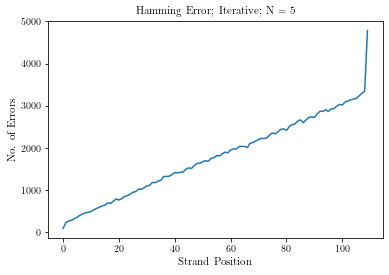

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:05<00:00, 1788.08it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


G -> A 11
T -> C 19
G -> T 20
G -> C 22
T -> G 24
C -> A 29
T -> A 30
A -> C 31
A -> G 33
A -> T 35
C -> T 37
C -> G 37
A ->  38
G ->  47
T ->  64
C ->  73
 -> A 1454
 -> G 1590
 -> T 1663
 -> C 1691


 -> G @ 54 6
 -> T @ 39 6
 -> T @ 29 6
 -> G @ 34 6
 -> T @ 101 6
 -> G @ 84 6
 -> G @ 90 6
 -> G @ 4 6
 -> T @ 30 6
 -> C @ 51 6
 -> A @ 8 6
 -> G @ 27 6
 -> A @ 3 6
 -> A @ 90 6
 -> A @ 91 6
 -> C @ 77 6
 -> A @ 76 6
 -> A @ 11 6
 -> A @ 37 6
 -> A @ 104 6
 -> T @ 9 6
 -> A @ 43 6
 -> A @ 46 6
 -> C @ 64 6
 -> A @ 49 6
 -> C @ 52 6
 -> A @ 62 6
 -> T @ 51 7
 -> T @ 14 7
 -> T @ 21 7
 -> T @ 61 7
 -> G @ 53 7
 -> G @ 77 7
 -> G @ 68 7
G -> A @ 110 7
 -> T @ 41 7
 -> T @ 71 7
 -> G @ 95 7
 -> C @ 75 7
 -> C @ 35 7
 -> G @ 14 7
 -> A @ 69 7
 -> G @ 18 7
 -> A @ 50 7
 -> G @ 21 7
 -> A @ 26 7
 -> A @ 20 7
 -> C @ 103 7
 -> A @ 97 7
 -> A @ 61 7
 -> G @ 33 7
 -> A @ 65 7
 -> A @ 81 7
 -> A @ 73 7
 -> A @ 101 7
 -> A @ 7 7
 -> G @ 13 7
 -> C @ 40 7
 -> G @ 15 7
 -> C @ 91 7
 -> C @ 41 7
 -> C @ 86 7
 -> A @ 14 7
 -> C @ 99 7
 -> C @ 96 7
 -> C @ 56 7
 -> C @ 6 8
 -> A @ 9 8
 -> T @ 3 8
 -> C @ 65 8
 -> A @ 84 8
 -> T @ 20 8
 -> C @ 66 8
 -> T @ 12 8
 -> C @ 68 8
 -> A @ 72 8
 -> A @ 16 8
 

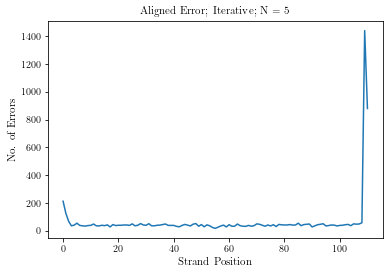

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[62, 33, 14, 12, 8, 10, 8, 9, 12, 13, 13, 17, 9, 10, 14, 9, 10, 11, 16, 9, 13, 13, 11, 13, 11, 12, 9, 11, 13, 15, 11, 17, 12, 5, 9, 7, 11, 15, 10, 10, 7, 7, 10, 8, 9, 10, 10, 11, 18, 4, 12, 6, 6, 8, 8, 3, 7, 13, 14, 8, 13, 10, 10, 12, 6, 8, 8, 13, 8, 12, 13, 18, 11, 9, 10, 7, 12, 6, 8, 5, 11, 12, 11, 9, 12, 16, 7, 12, 13, 19, 8, 7, 3, 11, 13, 8, 7, 11, 12, 7, 14, 15, 12, 7, 8, 13, 9, 9, 14, 366, 110]
[42, 29, 17, 8, 13, 16, 11, 11, 8, 6, 8, 16, 8, 9, 7, 10, 12, 10, 9, 9, 8, 7, 9, 10, 11, 16, 9, 11, 12, 6, 6, 12, 10, 10, 14, 11, 12, 18, 5, 6, 12, 7, 2, 9, 16, 10, 10, 13, 9, 8, 12, 7, 13, 11, 5, 4, 5, 8, 5, 8, 10, 7, 5, 11, 10, 9, 2, 4, 9, 4, 12, 7, 12, 5, 9, 10, 13, 13, 8, 11, 10, 12, 9, 9, 13, 12, 15, 12, 9, 9, 5, 13, 13, 11, 14, 9, 14, 12, 5, 10, 10, 6, 8, 13, 12, 20, 15, 10, 16, 391, 139]
[52, 32, 19, 8, 6, 13, 11, 8, 5, 9, 11, 9, 9, 7, 7, 7, 13, 2, 7, 10, 10, 7, 9, 8, 4, 5, 9, 6, 15, 13, 10, 9, 9, 7, 6, 9, 9, 8, 8, 12, 9, 8, 12, 11, 11, 10, 8, 9, 13, 14, 12, 4, 9, 7, 6, 5, 8, 9, 10,

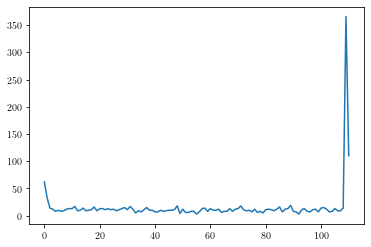

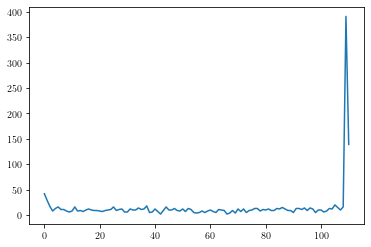

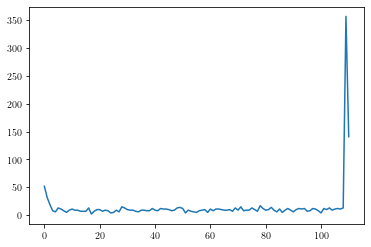

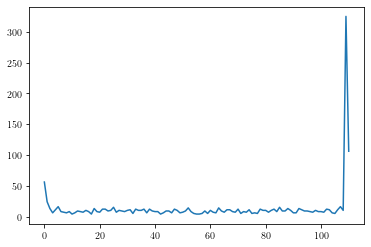

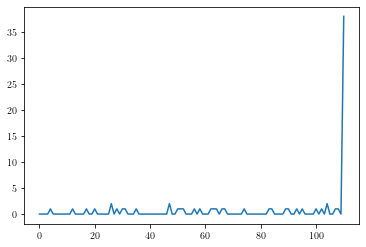

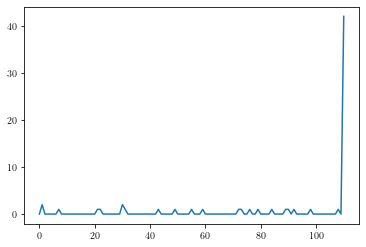

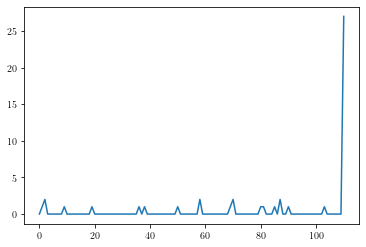

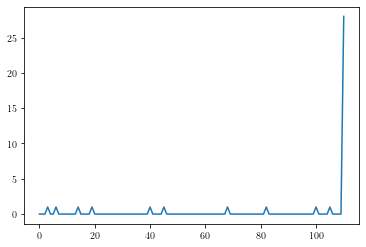

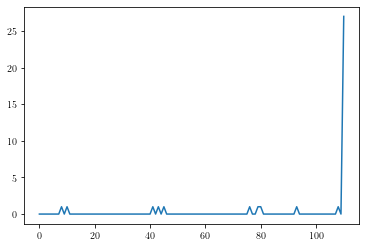

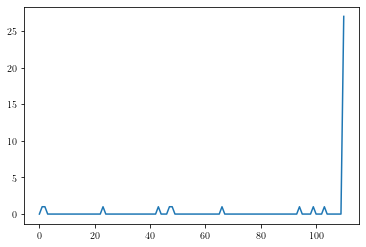

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)